# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
import networkx as nx

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-305.  -435.    85.5    5.     5.    85.5]
 [-295.  -435.    85.5    5.     5.    85.5]
 [-285.  -435.    85.5    5.     5.    85.5]
 ...
 [ 435.   465.     8.     5.     5.     8. ]
 [ 445.   465.     8.     5.     5.     8. ]
 [ 455.   465.     8.     5.     5.     8. ]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [4]:
# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision
from sampling import Sampler

In [5]:
sampler = Sampler(data)
polygons = sampler._polygons

In [6]:
# Example: sampling 100 points and removing
# ones conflicting with obstacles.
nodes = sampler.sample(1000)
print(len(nodes))

656


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [7]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree

In [8]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

In [9]:
import time
t0 = time.time()
g = create_graph(nodes, 10)
print('graph took {0} seconds to build'.format(time.time()-t0))

graph took 114.20952486991882 seconds to build


In [10]:
print("Number of edges", len(g.edges))

Number of edges 2528


## Step 4 - Visualize Graph

In [11]:
from grid import create_grid

In [12]:
grid = create_grid(data, sampler._zmax, 1)

-310.0 500.0
-440.0 470.0
810 910


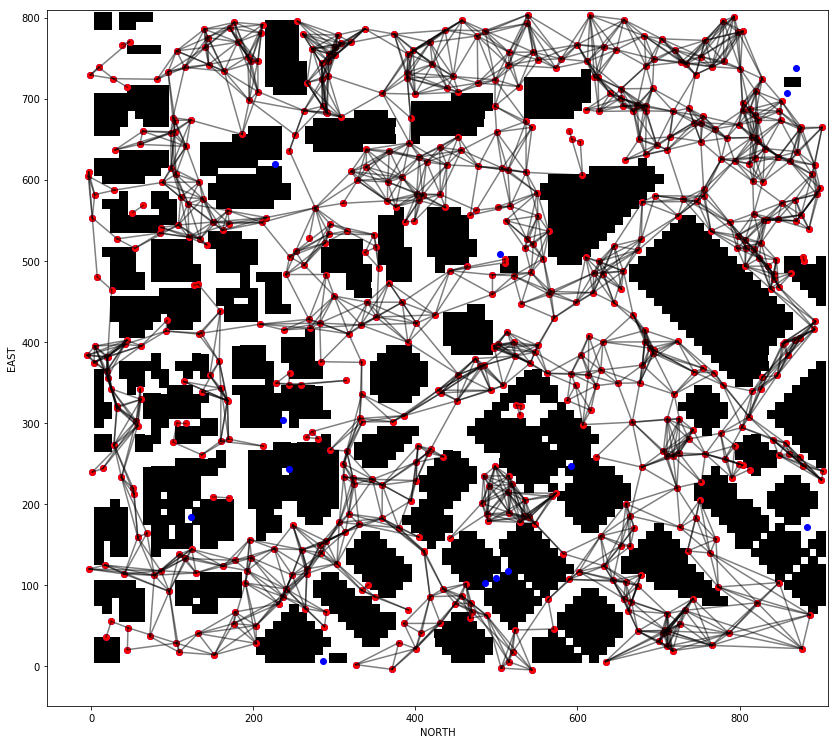

In [13]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# draw all nodes
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# draw connected nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [14]:
def heuristic(n1, n2):
    # TODO: complete
    return LA.norm(np.array(n2) - np.array(n1))

## Step 6 - Complete A*

In [15]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [16]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

160 643


In [17]:
t0 = time.time()
path, cost = a_star(g, heuristic, start, goal)
print('search took {0} seconds'.format(time.time()-t0))
print(len(path), path)

Found a path.
search took 0.0664973258972168 seconds
15 [(-203.60307853680212, 27.314273244855542, 14.443219372135232), (-237.98135614483078, 34.618500160377835, 0.48786976257187975), (-288.3477590285332, 84.90335589554468, 9.170813665664427), (-222.89985612016858, 128.80785398306944, 12.04363123326062), (-188.49062561475924, 166.80997196030307, 15.055237308223095), (-156.62328148571137, 218.27317768391595, 13.396464342109555), (-104.78903556242278, 225.14561260883545, 12.728652877533484), (-85.04021156966957, 287.65492166776176, 6.292122778650205), (-42.28328243087822, 290.4443816080121, 9.61568665273436), (-24.907393960682953, 302.45341761375664, 9.61506385968172), (-17.99360873508681, 341.5336445603492, 11.2738369757155), (33.99128705133961, 380.90450319183026, 9.048049011687517), (78.25658767376797, 424.41489932617253, 8.400198355569454), (120.13792844526415, 458.7170307248472, 0.9307241661169918), (162.8383887767705, 413.4690184149915, 13.055735283147376)]


In [18]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

(-203.60307853680212, 27.314273244855542, 14.443219372135232) (-237.98135614483078, 34.618500160377835, 0.48786976257187975)
(-237.98135614483078, 34.618500160377835, 0.48786976257187975) (-288.3477590285332, 84.90335589554468, 9.170813665664427)
(-288.3477590285332, 84.90335589554468, 9.170813665664427) (-222.89985612016858, 128.80785398306944, 12.04363123326062)
(-222.89985612016858, 128.80785398306944, 12.04363123326062) (-188.49062561475924, 166.80997196030307, 15.055237308223095)
(-188.49062561475924, 166.80997196030307, 15.055237308223095) (-156.62328148571137, 218.27317768391595, 13.396464342109555)
(-156.62328148571137, 218.27317768391595, 13.396464342109555) (-104.78903556242278, 225.14561260883545, 12.728652877533484)
(-104.78903556242278, 225.14561260883545, 12.728652877533484) (-85.04021156966957, 287.65492166776176, 6.292122778650205)
(-85.04021156966957, 287.65492166776176, 6.292122778650205) (-42.28328243087822, 290.4443816080121, 9.61568665273436)
(-42.28328243087822, 2

## Step 7 - Visualize Path

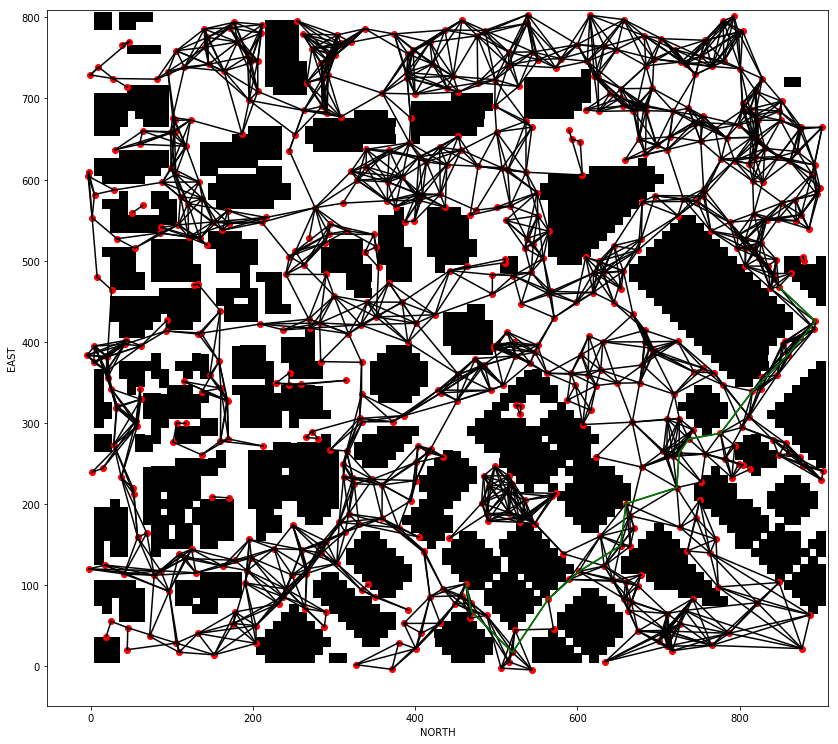

In [19]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)